## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной (0 или 1, а НЕ вероятность) для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 6 дней после окончания последнего вебинара (до 20:00 вс).
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлайна
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, learning_curve

# 3. Модели
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [3]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.24, 0.34, 20):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def filling_empty_cells_train(prizn):
    
    global X
    global X_nan
    
    # Масштабируем RandomForestRegressor, GradientBoostingRegressor
    #scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_nan = scaler.fit_transform(X_nan)
    
    # Обучаем модель и предсказываем пропущенные значения. Записываем их на место пропусков
    gbr = GradientBoostingRegressor(random_state=21)
    gbr.fit(X, y)
    y_pred = gbr.predict(X_nan)
    df_train.loc[df_train[prizn].isna(), prizn] = y_pred

In [6]:
def filling_empty_cells_test(prizn):
        
    global X
    global X_nan
    
    # Масштабируем
    #scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_nan = scaler.fit_transform(X_nan)
    
    # Обучаем модель и предсказываем пропущенные значения. Записываем их на место пропусков
    gbr = GradientBoostingRegressor(random_state=21)
    gbr.fit(X, y)
    y_pred = gbr.predict(X_nan)
    df_test.loc[df_test[prizn].isna(), prizn] = y_pred

**Пути к директориям и файлам**

In [7]:
TRAIN_DATASET_PATH = 'D:/repo/Python-Data-Science-2/course_project_train.csv'
TEST_DATASET_PATH = 'D:/repo/Python-Data-Science-2/course_project_test.csv'

**Загрузка тренировочных данных**

In [8]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Обзор количественных признаков**

In [9]:
df_train.shape

(7500, 17)

In [10]:
df_train.describe(include='all')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500,5.943000e+03,7129,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500,7500,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
unique,4,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,2,NaN,NaN,NaN,NaN,NaN
top,Home Mortgage,NaN,10+ years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debt consolidation,Short Term,NaN,NaN,NaN,NaN,NaN
freq,3637,NaN,2332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5944,5556,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.366392e+06,NaN,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,NaN,NaN,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,NaN,8.453392e+05,NaN,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,NaN,NaN,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,NaN,1.645970e+05,NaN,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,NaN,8.443410e+05,NaN,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,NaN,NaN,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,NaN,1.168386e+06,NaN,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,NaN,NaN,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,NaN,1.640137e+06,NaN,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,NaN,NaN,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000


**Обзор целевой переменной**

In [11]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

**Обзор номинативных/категориальных признаков**

In [12]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Приведение типов<a class="anchor" id="cast"></a>

In [13]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [14]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Заполняем пропуски признака 'Bankruptcies' модой**

In [15]:
df_train.loc[pd.isnull(df_train['Bankruptcies']), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]

**Удаляем категорию 'renewable energy'**

Поскольку в тестовой выборке у признака 'Purpose' нет категории 'renewable energy', и таких наблюдений всего 2, удалляем их из датасета

In [16]:
df_train = df_train.loc[~df_train['Purpose'].isin(['renewable energy'])]

**Переводим категории в числа**

In [17]:
df_train.replace({'Home Ownership':{'Home Mortgage':3, 'Rent':2, 'Own Home':1, 'Have Mortgage':3}, 
                  'Years in current job':{'10+ years':10, '2 years':2, '3 years':3, '< 1 year':0, '5 years':5, 
                                          '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}, 
                  'Purpose':{'debt consolidation':14, 'other':13, 'home improvements':12, 'business loan':11, 'buy a car':10, 
                             'medical bills':9, 'major purchase':8, 'take a trip':7, 'buy house':6, 'small business':5, 
                             'wedding':4, 'moving':3, 'educational expenses':2, 'vacation':1}, 
                  'Term':{'Short Term':0, 'Long Term':1}}, inplace = True)

#### Масштабируем

In [18]:
scaler = StandardScaler()

**Заполняем пропуски признака 'Annual Income', 'Months since last delinquent', 'Years in current job', 'Credit Score'**

ЗДЕСЬ ЗАПОЛНЯЕМ NaN-ЯЧЕЙКИ ПАРАМЕТРА **'Years in current job'**

Разделяем на два датасета.

X содержит признаки для обучения.

y - все известные значения параметра.

X_nan - строки с пропущенным признаком параметра.

In [19]:
X = df_train.drop(['Annual Income', 'Months since last delinquent', 'Years in current job', 'Credit Score'], axis = 'columns')[~df_train['Years in current job'].isna()]

y = df_train.loc[~df_train['Years in current job'].isna(), 'Years in current job'].astype(int)

X_nan = df_train.drop(['Annual Income', 'Months since last delinquent', 'Years in current job', 'Credit Score'], axis = 'columns')[df_train['Years in current job'].isna()]

In [20]:
filling_empty_cells_train('Years in current job')

ЗДЕСЬ ЗАПОЛНЯЕМ NaN-ЯЧЕЙКИ ПАРАМЕТРА **'Annual Income'**

In [21]:
X = df_train.drop(['Annual Income', 'Months since last delinquent', 'Credit Score'], axis = 'columns')[~df_train['Annual Income'].isna()]

y = df_train.loc[~df_train['Annual Income'].isna(), 'Annual Income'].astype(int)

X_nan = df_train.drop(['Annual Income', 'Months since last delinquent', 'Credit Score'], axis = 'columns')[df_train['Annual Income'].isna()]

In [22]:
filling_empty_cells_train('Annual Income')

ЗДЕСЬ ЗАПОЛНЯЕМ NaN-ЯЧЕЙКИ ПАРАМЕТРА **'Credit Score'**

In [23]:
X = df_train.drop(['Months since last delinquent', 'Credit Score'], axis = 'columns')[~df_train['Credit Score'].isna()]

y = df_train.loc[~df_train['Credit Score'].isna(), 'Credit Score'].astype(int)

X_nan = df_train.drop(['Months since last delinquent', 'Credit Score'], axis = 'columns')[df_train['Credit Score'].isna()]

In [24]:
filling_empty_cells_train('Credit Score')

ЗДЕСЬ ЗАПОЛНЯЕМ NaN-ЯЧЕЙКИ ПАРАМЕТРА **'Months since last delinquent'**

In [25]:
X = df_train.drop(['Months since last delinquent'], axis = 'columns')[~df_train['Months since last delinquent'].isna()]

y = df_train.loc[~df_train['Months since last delinquent'].isna(), 'Months since last delinquent'].astype(int)

X_nan = df_train.drop(['Months since last delinquent'], axis = 'columns')[df_train['Months since last delinquent'].isna()]

In [26]:
filling_empty_cells_train('Months since last delinquent')

In [27]:
df_train.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Построение модели классификации

**Выделение целевой переменной и групп признаков**

In [28]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

**Разбиение на train и test**

In [29]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((5248, 16), (2250, 16), (5248,), (2250,))

**Обучение модели на основе CatBoost**

In [30]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3776
           1       1.00      0.69      0.81      1472

    accuracy                           0.91      5248
   macro avg       0.94      0.84      0.88      5248
weighted avg       0.92      0.91      0.91      5248

TEST

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1611
           1       0.91      0.48      0.63       639

    accuracy                           0.84      2250
   macro avg       0.87      0.73      0.76      2250
weighted avg       0.85      0.84      0.82      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1582   29
1                334  305
Wall time: 6.37 s


### Подбор гиперпараметров CatBoost

In [31]:
from catboost import Pool

model_catb = catb.CatBoostClassifier(n_estimators=150,
                                     custom_loss=['F1'],
                                     silent=True, 
                                     random_state=21)
grid = {
    'learning_rate': [0.05, 0.1],
    'depth':[4, 5, 6, 7]
}
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

grid_search_results = model_catb.grid_search(grid, train_pool, cv=3, stratified=True,
                                             verbose=False, plot=False)


bestTest = 0.3548461737
bestIteration = 136


bestTest = 0.3466546029
bestIteration = 114


bestTest = 0.3530067163
bestIteration = 149


bestTest = 0.3489848046
bestIteration = 120


bestTest = 0.3493901044
bestIteration = 146


bestTest = 0.3464657751
bestIteration = 90


bestTest = 0.3511445398
bestIteration = 138


bestTest = 0.3519043729
bestIteration = 61



In [32]:
grid_search_results['params']

{'depth': 6, 'learning_rate': 0.1}

### Снижение степени переобучения

Перебором находим параметр **l2_leaf_reg=350**

In [33]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=100, 
                                      max_depth=6, 
                                      learning_rate=0.1,
                                      #l2_leaf_reg=350, 
                                      early_stopping_rounds=20,
                                      silent=True, 
                                      random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      3776
           1       0.98      0.49      0.65      1472

    accuracy                           0.85      5248
   macro avg       0.91      0.74      0.78      5248
weighted avg       0.87      0.85      0.84      5248

TEST

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1611
           1       0.96      0.46      0.62       639

    accuracy                           0.84      2250
   macro avg       0.89      0.72      0.76      2250
weighted avg       0.86      0.84      0.82      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1598   13
1                348  291
Wall time: 407 ms


### Выбор порога вероятности для определения класса

По результатам расчетов выбираем порог вероятности = **0,303**

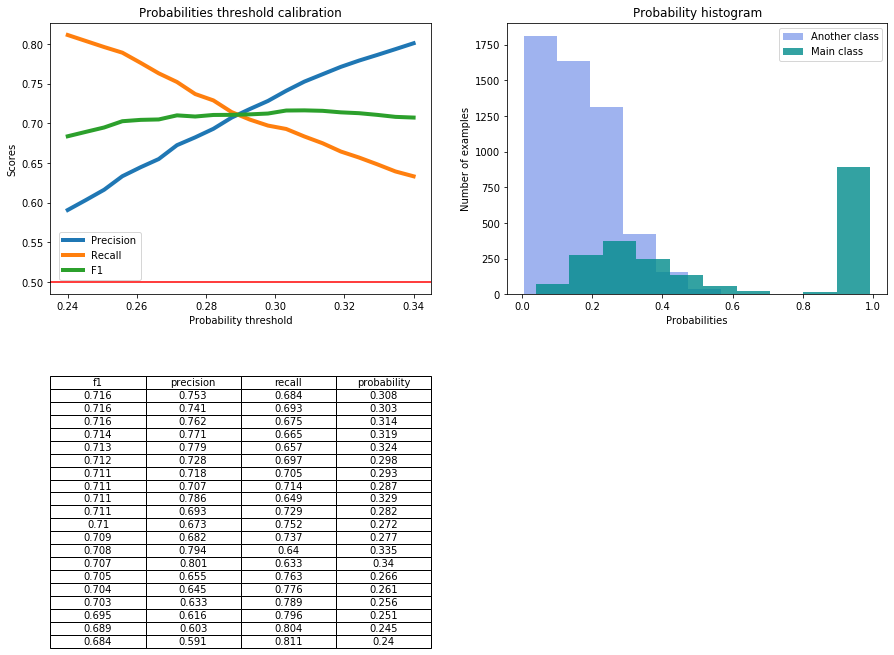

In [37]:
y_test_pred_probs = final_model.predict_proba(X_test)[:, 1]

show_proba_calibration_plots(y_test_pred_probs, y_test)

#### Обучаем модель на всем датасете df_train

In [36]:
%%time

X_train = df_train.drop(['Credit Default'], axis = 'columns')
y_train = df_train['Credit Default']
y_test = y_train


final_model = catb.CatBoostClassifier(n_estimators=100, 
                                      max_depth=6, 
                                      learning_rate=0.1,
                                      #l2_leaf_reg=350, 
                                      early_stopping_rounds=20,
                                      silent=True, 
                                      random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_train)
y_test_pred_probs = final_model.predict_proba(X_train)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      1.00      0.90      5387
           1       0.97      0.48      0.64      2111

    accuracy                           0.85      7498
   macro avg       0.90      0.74      0.77      7498
weighted avg       0.87      0.85      0.83      7498

TEST

              precision    recall  f1-score   support

           0       0.83      1.00      0.90      5387
           1       0.97      0.48      0.64      2111

    accuracy                           0.85      7498
   macro avg       0.90      0.74      0.77      7498
weighted avg       0.87      0.85      0.83      7498

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               5361    26
1               1104  1007
Wall time: 525 ms


## Прогнозирование на тестовом датасете

**Загрузка тестовых данных**

In [38]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


**Обзор количественных признаков**

In [39]:
df_test.shape

(2500, 16)

In [40]:
df_test.describe(include='all')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2500,1.987000e+03,2414,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2500,2500,2.500000e+03,2.500000e+03,2500.000000,1987.000000
unique,4,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,2,NaN,NaN,NaN,NaN
top,Home Mortgage,NaN,10+ years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debt consolidation,Short Term,NaN,NaN,NaN,NaN
freq,1225,NaN,810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1973,1861,NaN,NaN,NaN,NaN
mean,NaN,1.366922e+06,NaN,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,NaN,NaN,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,NaN,9.171252e+05,NaN,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,NaN,NaN,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,NaN,1.065330e+05,NaN,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,NaN,8.523115e+05,NaN,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,NaN,NaN,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,NaN,1.178475e+06,NaN,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,NaN,NaN,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,NaN,1.629734e+06,NaN,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,NaN,NaN,5.225825e+05,3.663485e+05,24146.000000,743.000000


**Обзор номинативных/категориальных признаков**

In [41]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving               

### Приведение типов<a class="anchor" id="cast"></a>

In [42]:
df_test.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [43]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

**Заполняем пропуски признака 'Bankruptcies' модой**

In [44]:
df_test.loc[pd.isnull(df_test['Bankruptcies']), 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]

**Переводим категории в числа**

In [45]:
df_test.replace({'Home Ownership':{'Home Mortgage':3, 'Rent':2, 'Own Home':1, 'Have Mortgage':3}, 
                  'Years in current job':{'10+ years':10, '2 years':2, '3 years':3, '< 1 year':0, '5 years':5, 
                                          '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}, 
                  'Purpose':{'debt consolidation':14, 'other':13, 'home improvements':12, 'business loan':11, 'buy a car':10, 
                             'medical bills':9, 'major purchase':8, 'take a trip':7, 'buy house':6, 'small business':5, 
                             'wedding':4, 'moving':3, 'educational expenses':2, 'vacation':1},
                  'Term':{'Short Term':0, 'Long Term':1}}, inplace = True)

#### Масштабируем

In [46]:
scaler = StandardScaler()

**Заполняем пропуски признака 'Annual Income', 'Months since last delinquent', 'Years in current job', 'Credit Score'**

ЗДЕСЬ ЗАПОЛНЯЕМ NaN-ЯЧЕЙКИ ПАРАМЕТРА **'Years in current job'**

In [47]:
X = df_test.drop(['Annual Income', 'Months since last delinquent', 'Years in current job', 'Credit Score'], axis = 'columns')[~df_test['Years in current job'].isna()]

y = df_test.loc[~df_test['Years in current job'].isna(), 'Years in current job'].astype(int)

X_nan = df_test.drop(['Annual Income', 'Months since last delinquent', 'Years in current job', 'Credit Score'], axis = 'columns')[df_test['Years in current job'].isna()]

In [48]:
filling_empty_cells_test('Years in current job')

ЗДЕСЬ ЗАПОЛНЯЕМ NaN-ЯЧЕЙКИ ПАРАМЕТРА **'Annual Income'**

In [49]:
X = df_test.drop(['Annual Income', 'Months since last delinquent', 'Credit Score'], axis = 'columns')[~df_test['Annual Income'].isna()]

y = df_test.loc[~df_test['Annual Income'].isna(), 'Annual Income'].astype(int)

X_nan = df_test.drop(['Annual Income', 'Months since last delinquent', 'Credit Score'], axis = 'columns')[df_test['Annual Income'].isna()]

In [50]:
filling_empty_cells_test('Annual Income')

ЗДЕСЬ ЗАПОЛНЯЕМ NaN-ЯЧЕЙКИ ПАРАМЕТРА **'Credit Score'**

In [51]:
X = df_test.drop(['Months since last delinquent', 'Credit Score'], axis = 'columns')[~df_test['Credit Score'].isna()]

y = df_test.loc[~df_test['Credit Score'].isna(), 'Credit Score'].astype(int)

X_nan = df_test.drop(['Months since last delinquent', 'Credit Score'], axis = 'columns')[df_test['Credit Score'].isna()]

In [52]:
filling_empty_cells_test('Credit Score')

ЗДЕСЬ ЗАПОЛНЯЕМ NaN-ЯЧЕЙКИ ПАРАМЕТРА **'Months since last delinquent'**

In [53]:
X = df_test.drop(['Months since last delinquent'], axis = 'columns')[~df_test['Months since last delinquent'].isna()]

y = df_test.loc[~df_test['Months since last delinquent'].isna(), 'Months since last delinquent'].astype(int)

X_nan = df_test.drop(['Months since last delinquent'], axis = 'columns')[df_test['Months since last delinquent'].isna()]

In [54]:
filling_empty_cells_test('Months since last delinquent')

In [55]:
df_test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

### Предсказываем целевую переменную, используя модель, построенную на обучающем датасете

#### Делаем предсказание на тестовых данных

In [56]:
y_test_pred_probs = final_model.predict_proba(df_test)[:, 1]

#### Сдвигаем порог вероятности и сохраняем предсказания

In [57]:
y_test_labels = np.array(y_test_pred_probs > 0.303, dtype=int)

pd.DataFrame(y_test_labels).to_csv('M_Salyaev_predictions_02.csv', header=None, index=None)